<a href="https://colab.research.google.com/github/SuperCoolCucumber/practice/blob/main/FM_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The chosen expressive *damn* is:


*   Independent (it has some connotative meaning that adds extra to the regular descriptive attributes, as in *the music was pretty damn good too*) 
*   Nondisplaceable (it asserts that the person who produced the utterance is feeling something extreme, as in *it will remain stuck in my damn cartrage slot of my forgotten n64* - the user liked tha game so much they would like it to stay stuck in their gaming console)
*   Perspectively dependent (it can vary its meaning from extremely good, as in *it's so  damn fun*, to extremely bad, as in *you just don't give a damn about playing it again*)
*   Descriptively ineffable (the emotional content of *the music is damn awesome* is not the same as *the music is awesome*, as *damn* intensifies the adjective right next to it)
* Immediate (in *every game can't be perfect but this game comes damn close* the word *damn* does not offer any meaningful content so much as inflict it)

Hence, *damn* is an expressive.

The type of profile that could be assumed for this expressive is U-shaped, since *damn* is extensively used in both bad (*I don't recommend this for any god damn gamer*, *The graphics are pretty damn ugly*) and good (*Goddamn I love this game*, *I'll be damned if I've never enjoyed reading and playing a video game more than I did with Torment*) reviews.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import sklearn
from sklearn import feature_extraction
from collections import defaultdict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz

--2021-10-11 20:59:33--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz.2’

Video_Games_5.json. 100%[===================>] 146.91M  71.3MB/s    in 2.1s    

2021-10-11 20:59:35 (71.3 MB/s) - ‘Video_Games_5.json.gz.2’ saved [154050105/154050105]



In [3]:
data = pd.read_json('/content/Video_Games_5.json.gz', lines=True)

In [4]:
# taking 20,000 samples from the dataset 

text = data[['overall', 'reviewText']].sample(20000).dropna().reset_index()

In [5]:
vect = sklearn.feature_extraction.text.CountVectorizer()

In [6]:
X = vect.fit_transform(text['reviewText'].values)

In [7]:
# matching and filtering the occurences of the word damn

tokens = [(i, item) for i, item in enumerate(vect.get_feature_names()) if 'damn' in item.lower()]

In [8]:
tokens

[(9658, 'damn'),
 (9659, 'damnation'),
 (9660, 'damned'),
 (9661, 'damnit'),
 (9662, 'damnright'),
 (16223, 'goddamned')]

In [9]:
token_array = X.toarray()


In [10]:
expressive = defaultdict(list)
for i, row in enumerate(token_array):
  for index, token in tokens:
    if row[index]:
      expressive[token].append((i, row[index]))




In [11]:
# Allocate empty array for the frequency of the expressive
freq = np.zeros_like(text['reviewText'].values)
for k, v in expressive.items():
  for idx, fr in v:
    freq[idx] = float(fr)

text['expressiveFreq'] = freq

text['expressiveFreq'] = pd.to_numeric(text['expressiveFreq'])


In [12]:
# counting the number of tokens of the dataset per sample

text['numTokens'] = text['reviewText'].apply(lambda text:
                         len(
                            set(
                                map(
                                  lambda item: item.lower(),
                                  text.split(' ')
                                  )
                                )
                            )
                         )

In [13]:
text = text[text['expressiveFreq'] != 0]
text.dropna(inplace=True)
# Calculate the log-odds
text['log-odds'] = text[['expressiveFreq', 'numTokens']].apply(
    lambda item: np.log(item.expressiveFreq / ((item.numTokens - item.expressiveFreq ))),
    axis=1
)

In [14]:
text['log-odds'].replace([np.inf, -np.inf], np.nan, inplace=True)
text.dropna(inplace=True)

In [15]:
text_agg = text[text['expressiveFreq'] != 0].groupby(['overall'], as_index=False).mean()

In [16]:
text_agg

,overall,index,expressiveFreq,numTokens,log-odds
0,1,297995.636364,1.363636,279.090909,-4.743060
1,2,180675.500000,1.000000,218.250000,-4.974269
2,3,187716.041667,1.083333,318.000000,-5.449137
3,4,196423.647059,1.029412,236.794118,-5.067176
4,5,217924.078947,1.026316,229.289474,-5.040487


In [17]:
# since the data is non-linear we use polynomial regression of degree 5 to regress the points
model = make_pipeline(PolynomialFeatures(5), Ridge(alpha=1e-3))
model.fit(text_agg['overall'].values.reshape(-1, 1), text_agg['log-odds'].values.reshape(-1, 1))
y_pred = model.predict(np.linspace(1, 5, 100).reshape(-1, 1))


In [18]:
model_freq = make_pipeline(PolynomialFeatures(5), Ridge(alpha=1e-3))
model_freq.fit(text_agg['overall'].values.reshape(-1, 1), text_agg['expressiveFreq'].values.reshape(-1, 1))
y_pred_freq = model_freq.predict(np.linspace(1, 5, 100).reshape(-1, 1))

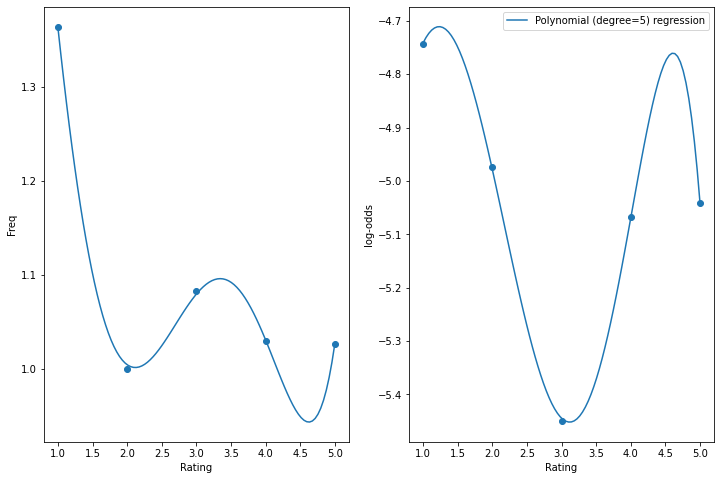

In [20]:
# Plotting the results

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
# axs[0].scatter(
#     text[text['expressiveFreq'] != 0]['overall'].values,
#     text[text['expressiveFreq'] != 0]['expressiveFreq'].values,
#     alpha=0.01
#     )
axs[0].scatter(
    text_agg['overall'].values,
    text_agg['expressiveFreq'].values
    )
axs[0].plot(
    np.linspace(1, 5, 100),
    y_pred_freq,
    label='Polynomial (degree=5) regression'
    )
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Freq')
# axs[1].scatter(
#     text[text['expressiveFreq'] != 0]['overall'].values,
#     text[text['expressiveFreq'] != 0]['log-odds'].values,
#     alpha=0.01
#     )
axs[1].scatter(
    text_agg['overall'].values,
    text_agg['log-odds'].values
    )
axs[1].plot(
    np.linspace(1, 5, 100),
    y_pred,
    label='Polynomial (degree=5) regression'
    )
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('log-odds')
plt.legend()